# Applying Locally Linear Deep Learner on Synthetic data
This synthetic dataset is generated by expanding a 'circle' in 50 dimensions and shaping it with sine-wave perturbations. The dataset is split into clusters using hierarchical clustering, then split into two classes using logistic regression. Finally, for each cluster, 70% (35 out of 50) of the features are randomly selected and replaced with noise (cluster-specific noise).

Objectives:
1) Visualize synthetic data (by PCA) as a comparison to the PCA plot of various types of chemicals  
2) Compare global feature selection (by RF feature importances) and instance-based feature selection (by COSA)  
3) Compare Random Forest and other machine learning methods against Locally linear deep learner  


In [1]:
%env TMPDIR=/tmp/temp 
#For joblib multi-threading

import os, sys
import numpy as np

code_folder=os.path.join(os.getcwd(), "..", "0_code")
sys.path.append(code_folder)

env: TMPDIR=/tmp/temp


In [2]:
#Copied on 15/12/20

# u_gen=lambda x: np.concatenate([np.random.exponential(1, 3), np.random.exponential(0.01, x-3)]) #Shaping the manifold meaningfully in 3 dimensions

from data_generation import Synthetic
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

n_points=1000
n_dim=10
n_clusters=10
data_gen=Synthetic.LocallyLinearManifold(n_points=n_points,
                               n_dim=n_dim,
                               n_clusters=n_clusters,
                               n_knn=10,
                               n_shape_manifold=100,
                               d_shape_manifold=0.25,
                               u_gen='random',
                               clf=LogisticRegression(penalty='l2', 
                                                       solver='lbfgs', 
                                                       C=10, 
                                                       class_weight='balanced'
                                                      ),
                               prior=0.1,
                               preprocessing=preprocessing.MinMaxScaler(),
                               random_seed=123,
                               verbose=True
                              )
X,y=data_gen.fit()

Class probabilities differ from pre-set parameter greater than `balanced_tol`
After 10 iterations: LR1 score: 0.9473684210526315
(array([0, 1]), array([112,  21], dtype=int64))
LR2 score: 1.0
No. of reassignments: 9 out of 133
(array([0, 1]), array([103,  30], dtype=int64))
Class probabilities differ from pre-set parameter greater than `balanced_tol`
After 10 iterations: LR1 score: 0.8533333333333334
(array([0, 1]), array([56, 19], dtype=int64))
LR2 score: 1.0
No. of reassignments: 3 out of 75
(array([0, 1]), array([53, 22], dtype=int64))
Class probabilities differ from pre-set parameter greater than `balanced_tol`
After 10 iterations: LR1 score: 0.9411764705882353
(array([0, 1]), array([100,  19], dtype=int64))
LR2 score: 1.0
No. of reassignments: 5 out of 119
(array([0, 1]), array([95, 24], dtype=int64))
Class probabilities differ from pre-set parameter greater than `balanced_tol`
After 10 iterations: LR1 score: 0.9714285714285714
(array([0, 1]), array([91, 14], dtype=int64))
LR2 sco

In [3]:
#Add cluster-specific noise (Should this step go before binary classification or after?)
## May no longer be a smooth manifold :(

import copy 
n_dim_noise=n_dim-3

all_noise_features=[]
means = [np.mean(X[:,i]) for i in range(X.shape[1])]
stds = [np.std(X[:,i]) for i in range(X.shape[1])]
X_noise = copy.deepcopy(X)
np.random.seed(123)
for cl in range(n_clusters):
    cl_ind=np.where(data_gen.cluster_labels==cl)[0]
    noise_features=np.sort(np.random.choice(range(n_dim), n_dim_noise, replace=False))
    all_noise_features.append(noise_features)
    for j in noise_features:
        X_noise[cl_ind, j]=np.random.normal(means[j], stds[j], size=len(cl_ind))
# X_noise=X+X_noise

In [4]:
from sklearn import preprocessing
def get_split(cluster_labels, prop=0.1):
    unique_labels=np.unique(cluster_labels)
    n_test=int(prop*len(cluster_labels))
    n_test_list=[int(n_test/len(unique_labels)) for i in range(len(unique_labels))]
    for i in np.random.choice(unique_labels, replace=False, size=n_test%len(unique_labels)):
        n_test_list[i]+=1
    test_inds=np.concatenate([np.random.choice(np.where(cluster_labels==unique_labels[i])[0],
                                replace=False, 
                                size=n_test_list[i]
                               ) for i in range(len(unique_labels))
                             ])
    test_inds=np.sort(test_inds)
    train_inds=np.setdiff1d(range(len(cluster_labels)), test_inds)
    return train_inds, test_inds

X_scaled=preprocessing.scale(X_noise)
np.random.seed(123)
train_inds, test_inds=get_split(data_gen.cluster_labels)
X_train=X_scaled[train_inds]
X_test=X_scaled[test_inds]
y_train=y[train_inds]
y_test=y[test_inds]
cluster_labels_train=data_gen.cluster_labels[train_inds]
cluster_labels_test=data_gen.cluster_labels[test_inds]

In [5]:
import pandas as pd

X_train_df=pd.DataFrame(X_train, columns=[f"feat_{i:0>3d}" for i in range(X_train.shape[1])])
X_train_df['Type']='Training'
X_train_df['cluster_labels']=cluster_labels_train
X_train_df['Class']=y_train

X_test_df=pd.DataFrame(X_test, columns=[f"feat_{i:0>3d}" for i in range(X_train.shape[1])])
X_test_df['Type']='Testing'
X_test_df['cluster_labels']=cluster_labels_test
X_test_df['Class']=y_test

df=pd.concat([X_train_df, X_test_df])
cols=df.columns[np.concatenate([[10,11,12],range(10)])]
df=df[cols]

# SynthDataFolder="SynthData_10dim_clusternoise"
# df.to_csv(os.path.join(SynthDataFolder, 
#                        "SynthData_10dim_clusternoise.csv"
#                       ))
SynthDataFolder="SynthData_10dim_clusternoise_unbalanced"
df.to_csv(os.path.join(SynthDataFolder, 
                       "SynthData_10dim_clusternoise_unbalanced.csv"
                      ))

In [6]:
for i in range(n_clusters):
    counts=np.unique(df.query("cluster_labels == @i")['Class'], return_counts=True)[1]
    prior=counts[1]/np.sum(counts)
    print(f"{prior:.3f}")

0.226
0.293
0.202
0.143
0.255
0.394
0.351
0.316
0.307
0.233


In [4]:
# Save no-noise dataset
#Copied from above on 18/2/21
#Copied on 15/12/20

# u_gen=lambda x: np.concatenate([np.random.exponential(1, 3), np.random.exponential(0.01, x-3)]) #Shaping the manifold meaningfully in 3 dimensions

from data_generation import Synthetic
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

n_points=1000
n_dim=10
n_clusters=50
data_gen=Synthetic.LocallyLinearManifold(n_points=n_points,
                               n_dim=n_dim,
                               n_clusters=n_clusters,
                               n_knn=10,
                               n_shape_manifold=100,
                               d_shape_manifold=0.25,
                               u_gen='random',
                               clf=LogisticRegression(penalty='l2', 
                                                       solver='lbfgs', 
                                                       C=10, 
                                                       class_weight='balanced'
                                                      ),
                               prior=0.5,
                                n_iter=5,
                               preprocessing=preprocessing.MinMaxScaler(),
                               random_seed=123,
                               verbose=True
                              )
X,y=data_gen.fit()

from sklearn import preprocessing
def get_split(cluster_labels, prop=0.1):
    unique_labels=np.unique(cluster_labels)
    n_test=int(prop*len(cluster_labels))
    n_test_list=[int(n_test/len(unique_labels)) for i in range(len(unique_labels))]
    for i in np.random.choice(unique_labels, replace=False, size=n_test%len(unique_labels)):
        n_test_list[i]+=1
    test_inds=np.concatenate([np.random.choice(np.where(cluster_labels==unique_labels[i])[0],
                                replace=False, 
                                size=n_test_list[i]
                               ) for i in range(len(unique_labels))
                             ])
    test_inds=np.sort(test_inds)
    train_inds=np.setdiff1d(range(len(cluster_labels)), test_inds)
    return train_inds, test_inds


X_scaled=preprocessing.scale(X)
np.random.seed(123)
train_inds, test_inds=get_split(data_gen.cluster_labels)
X_train=X_scaled[train_inds]
X_test=X_scaled[test_inds]
y_train=y[train_inds]
y_test=y[test_inds]
cluster_labels_train=data_gen.cluster_labels[train_inds]
cluster_labels_test=data_gen.cluster_labels[test_inds]

import pandas as pd

X_train_df=pd.DataFrame(X_train, columns=[f"feat_{i:0>3d}" for i in range(X_train.shape[1])])
X_train_df['Type']='Training'
X_train_df['cluster_labels']=cluster_labels_train
X_train_df['Class']=y_train

X_test_df=pd.DataFrame(X_test, columns=[f"feat_{i:0>3d}" for i in range(X_train.shape[1])])
X_test_df['Type']='Testing'
X_test_df['cluster_labels']=cluster_labels_test
X_test_df['Class']=y_test

df=pd.concat([X_train_df, X_test_df])
cols=df.columns[np.concatenate([[10,11,12],range(10)])]
df=df[cols]

SynthDataFolder="SynthData_10dim_nonoise"
df.to_csv(os.path.join(SynthDataFolder, 
                       "SynthData_10dim_nonoise.csv"
                      ))

After 1 iterations: LR1 score: 1.0
(array([0, 1]), array([5, 4], dtype=int64))
LR2 score: 1.0
No. of reassignments: 0 out of 9
(array([0, 1]), array([5, 4], dtype=int64))
After 1 iterations: LR1 score: 0.9444444444444444
(array([0, 1]), array([20, 16], dtype=int64))
LR2 score: 1.0
No. of reassignments: 2 out of 36
(array([0, 1]), array([22, 14], dtype=int64))
Class probabilities differ from pre-set parameter greater than `balanced_tol`
After 5 iterations: LR1 score: 0.9
(array([0, 1]), array([6, 4], dtype=int64))
LR2 score: 1.0
No. of reassignments: 0 out of 10
(array([0, 1]), array([6, 4], dtype=int64))
After 1 iterations: LR1 score: 1.0
(array([0, 1]), array([7, 6], dtype=int64))
LR2 score: 1.0
No. of reassignments: 0 out of 13
(array([0, 1]), array([7, 6], dtype=int64))
After 1 iterations: LR1 score: 0.9615384615384616
(array([0, 1]), array([14, 12], dtype=int64))
LR2 score: 1.0
No. of reassignments: 0 out of 26
(array([0, 1]), array([14, 12], dtype=int64))
After 1 iterations: LR1 s

LR2 score: 1.0
No. of reassignments: 0 out of 26
(array([0, 1]), array([13, 13], dtype=int64))
After 1 iterations: LR1 score: 0.9642857142857143
(array([0, 1]), array([13, 15], dtype=int64))
LR2 score: 1.0
No. of reassignments: 0 out of 28
(array([0, 1]), array([13, 15], dtype=int64))
After 1 iterations: LR1 score: 0.9642857142857143
(array([0, 1]), array([15, 13], dtype=int64))
LR2 score: 1.0
No. of reassignments: 1 out of 28
(array([0, 1]), array([16, 12], dtype=int64))
After 1 iterations: LR1 score: 0.9166666666666666
(array([0, 1]), array([7, 5], dtype=int64))
LR2 score: 1.0
No. of reassignments: 0 out of 12
(array([0, 1]), array([7, 5], dtype=int64))
After 1 iterations: LR1 score: 0.8571428571428571
(array([0, 1]), array([14, 14], dtype=int64))
LR2 score: 1.0
No. of reassignments: 2 out of 28
(array([0, 1]), array([16, 12], dtype=int64))
After 1 iterations: LR1 score: 0.9166666666666666
(array([0, 1]), array([14, 10], dtype=int64))
LR2 score: 1.0
No. of reassignments: 0 out of 24


## Visualization of dataset using PCA

2D plot

In [71]:
# Copied from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html on 26/12/20

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


<IPython.core.display.Javascript object>


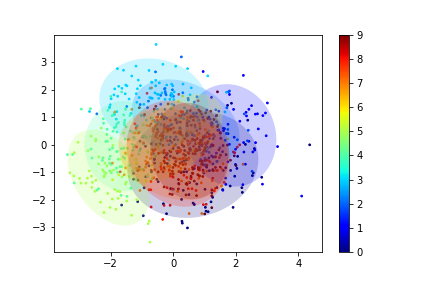

In [104]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2, svd_solver='full')
out=pca.fit_transform(X_train)

# Plot by cluster
C=cluster_labels_train
normalize = mcolors.Normalize(vmin=np.min(C), vmax=np.max(C))
colormap = cm.jet

fig,ax=plt.subplots()
for i in range(len(np.unique(C))):
    cl_ind=np.where(C==i)[0]
    scatter=ax.scatter(out[cl_ind,0], out[cl_ind,1], c=colormap(normalize(C[cl_ind])), s=3) 
    confidence_ellipse(out[cl_ind,0], out[cl_ind,1], ax, n_std=2.0, facecolor=colormap(normalize(i)), alpha=0.2)
    
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(C)
plt.colorbar(scalarmappable)
plt.savefig(os.path.join(SynthDataFolder,"PCA_2D"))

### Draw 3D prediction ellipse
Approach taken from https://blogs.sas.com/content/iml/2014/07/23/prediction-ellipses-from-covariance.html  
"  
1. Find the eigenvalues (λ1 and λ2) and eigenvectors (e1 and e2) of the covariance matrix, S. The eigenvectors form an orthogonal basis for the coordinate system for plotting the ellipse. The first eigenvector (e1) points in the direction of the greatest variance and defines the major axis for the prediction ellipse. The second eigenvector (e2) points in the direction of the minor axis.  
2. As mentioned previously, sines and cosines parameterize an ellipse whose axes are aligned with the standard coordinate directions. It is just as simple to parameterize an ellipse in the coordinates defined by the eigenvectors: 
    The eigenvectors have unit length, so a circle is formed by the linear combination cos(t)*e1 + sin(t)*e2 for t in the interval [0, 2π].  
    The ellipse sqrt(λ1)cos(t)*e1 + sqrt(λ2)sin(t)*e2 is a "standardized ellipse" in the sense that the standard deviations of the variables are used to scale the semi-major axes.  
3. To get a prediction ellipse, scale the standardized ellipse by a factor that depends on quantiles of the F2,n-2 distribution, the confidence level, and an adjustment factor that depends on the sample size n. The SAS/IML module contains the details.
4. Translate the prediction ellipse by adding the vector m.   
"  

Equations for 3D-ellipsoid:

$r = \frac{1}{\sqrt{\left ((\cos(\phi)/a)^2 + (\sin(\phi)/b)^2)\sin(\theta)^2 + (\cos(\theta)/c)^2 \right )}}$

$x=r\cos(\psi)\sin(\theta) $  
$y=r\sin(\psi)\sin(\theta) $  
$z=r\cos(\theta)$  



Sample only psi (0,2pi), theta fixed at pi/2. linear combination (dot product) of eigenvectors and (x,y,z)

In [109]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3, svd_solver='full')
out=pca.fit_transform(X_train)

In [110]:
def get_ellipse_in_3D(means, eig_vec, eig_val, d_angle=np.pi/20, n_std=2.0):
    # Get points on the circle around unit sphere (x**2 + y**2 = 1), then project onto the 3 principal semi-axes. 
    # Stretch principal semi-axes by n_std, then translate ellipse by means
    ### TBD: Figure out how to ensure that z-axis is the minor semi-axes in ellipse
    
    #Sort (descending) eig_val and eig_vec
    if eig_val.ndim==2:
        eig_val=np.diag(eig_val)        
    order=np.argsort(eig_val)[::-1]
    eig_val=eig_val[order]
    eig_vec=eig_vec[:,order]
    
    psi=np.arange(0, 2*np.pi, d_angle)
    theta=np.pi/2
    rot= lambda psi, theta: np.array([np.cos(psi)*np.sin(theta), 
                                      np.sin(psi)*np.sin(theta),
                                      np.cos(theta)
                                     ])
    points=[rot(p, theta) for p in psi] #points in a circle around a unit sphere
    std_scale=np.sqrt(eig_val)*n_std    
    ellipse_vec=np.multiply(std_scale, eig_vec) #Scale eigenvectors by std_scale
    points=[np.dot(p, ellipse_vec.transpose()) for p in points] #Points in an ellipse around the ellipsoid
    
    points=points+means #Translate ellipse 
    points=np.concatenate([points, [points[0]]])
    return points

In [111]:
import matplotlib
matplotlib.get_backend()

'nbAgg'

<IPython.core.display.Javascript object>


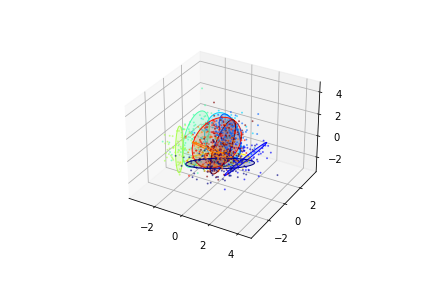

In [135]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure()
ax = fig.gca(projection='3d')

C=cluster_labels_train
normalize = mcolors.Normalize(vmin=np.min(C), vmax=np.max(C))

for cl in np.unique(C):
    cl_ind=np.where(cluster_labels_train==cl)[0]
    S=np.cov(out[cl_ind,:3].transpose())
    eig_val, eig_vec = np.linalg.eig(S)
    means=np.mean(out[cl_ind,:3], axis=0)

    c=colormap(normalize(C[cl_ind]))[0]
    ax.scatter(out[cl_ind,0], out[cl_ind,1], out[cl_ind,2], s=1, color=c, alpha=0.5)

#     Plot 3D ellipse based on mean and std of the points
    points=get_ellipse_in_3D(means, eig_vec, eig_val)
    verts = [list(zip(points[:,0], points[:,1], points[:,2]))]
    ax.add_collection3d(Poly3DCollection(verts, color=c, alpha=0.2),)

# plt.savefig(os.path.join(SynthDataFolder,"PCA_3D"))

<IPython.core.display.Javascript object>


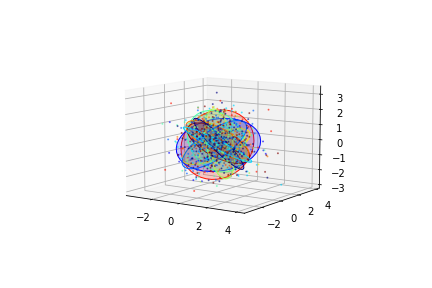

In [137]:
#Compare against randomly-generated normal noise

pca=PCA(n_components=3, svd_solver='full')
out2=pca.fit_transform(np.random.normal(size=X_train.shape))

fig = plt.figure()
ax = fig.gca(projection='3d')

C=cluster_labels_train
normalize = mcolors.Normalize(vmin=np.min(C), vmax=np.max(C))
colormap = cm.jet

for cl in np.unique(C):
    cl_ind=np.where(cluster_labels_train==cl)[0]
    S=np.cov(out2[cl_ind,:3].transpose())
    eig_val, eig_vec = np.linalg.eig(S)
    means=np.mean(out2[cl_ind,:3], axis=0)

    c=colormap(normalize(C[cl_ind]))[0]
    ax.scatter(out2[cl_ind,0], out2[cl_ind,1], out2[cl_ind,2], s=1, color=c, alpha=0.5)

    #Plot 3D ellipse based on mean and std of the points
    points=get_ellipse_in_3D(means, eig_vec, eig_val)
    verts = [list(zip(points[:,0], points[:,1], points[:,2]))]
    ax.add_collection3d(Poly3DCollection(verts, color=c, alpha=0.2),)
    


### 2 Visualizing the effects of feature selection/weighting

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def plot_reduced_dimension(points, C, colormap=cm.jet, title=None, save_file=None):
    normalize=mcolors.Normalize(vmin=np.min(C), vmax=np.max(C))
    
    fig, ax=plt.subplots()
    scatter=ax.scatter(points[:,0], points[:,1], c=colormap(normalize(C)), s=3)
    
    scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappable.set_array(C)
    plt.colorbar(scalarmappable)
    if title:
        plt.title(title)
    if save_file:
        plt.savefig(save_file)
    return fig

Training neural network
Epoch 1/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.9969
Epoch 2/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.1698
Epoch 3/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.2802
Epoch 4/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.4997
Epoch 5/1000
8/8 [==============================] - 0s 18ms/step - loss: 1.7786
Epoch 6/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.7117
Epoch 7/1000
8/8 [==============================] - 0s 18ms/step - loss: 1.4561
Epoch 8/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.1638
Epoch 9/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.1725
Epoch 10/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.2736
Epoch 11/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.2204
Epoch 12/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.2836
Epoch 13/1000

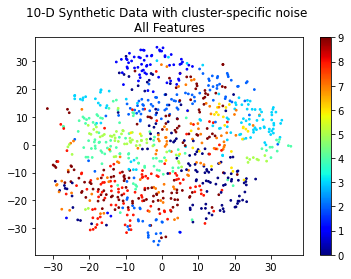

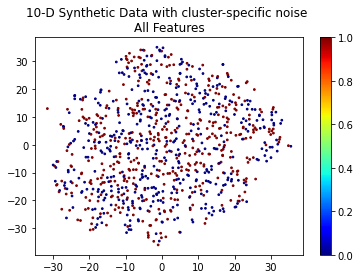

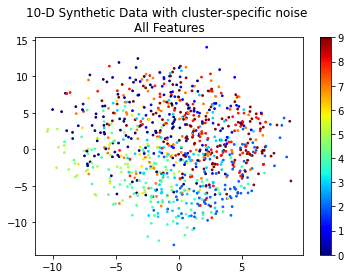

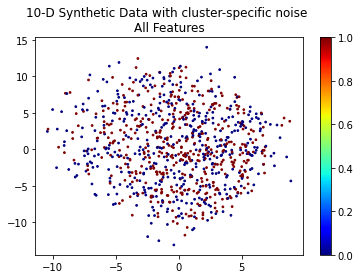

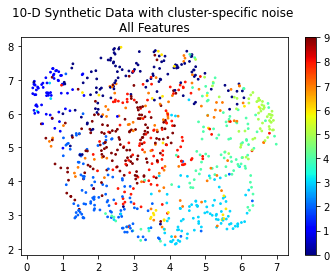

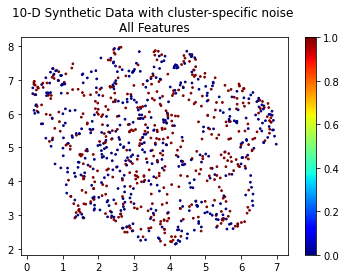

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

#No feature selection

from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
dr=TSNE(n_components=2)
np.random.seed(123)
out=dr.fit_transform(X_train)

#Plot by cluster
fig=plot_reduced_dimension(out, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nAll Features", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_AllFeatures_cluster_tSNE"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(out, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nAll Features", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_AllFeatures_class_tSNE"
                                                 )
                          )

from scipy.spatial.distance import pdist, squareform
import ivis
n_neighbors=15
Dmat=pdist(X_train, metric='euclidean')
neighbour_matrix=np.argsort(squareform(Dmat), axis=1)[:,:n_neighbors]

ivis_model=ivis.Ivis(k=n_neighbors, embedding_dims=2, 
          model='maaten', neighbour_matrix=neighbour_matrix, verbose=1)
ivis_model.fit(X_train, verbose=0)

ivis_embedding=ivis_model.transform(X_train)

#Plot by cluster
fig=plot_reduced_dimension(ivis_embedding, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nAll Features", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_AllFeatures_cluster_ivis"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(ivis_embedding, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nAll Features", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_AllFeatures_class_ivis"
                                                 )
                          )

import umap
n_neighbors=15

reducer=umap.UMAP(metric='euclidean', n_neighbors=n_neighbors)
umap_embedding=reducer.fit_transform(X_train)

#Plot by cluster
fig=plot_reduced_dimension(umap_embedding, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nAll Features", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_AllFeatures_cluster_umap"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(umap_embedding, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nAll Features", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_AllFeatures_class_umap"
                                                 )
                          )

Training neural network
Epoch 1/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.4719
Epoch 2/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.4291
Epoch 3/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.5287
Epoch 4/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.5113
Epoch 5/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.5406
Epoch 6/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.4796
Epoch 7/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.6250
Epoch 8/1000
8/8 [==============================] - 0s 18ms/step - loss: 0.7037
Epoch 9/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.5540
Epoch 10/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.5984
Epoch 11/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.5582
Epoch 12/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.6219
Epoch 13/1000

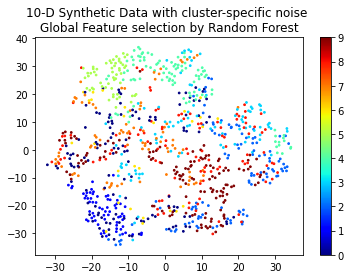

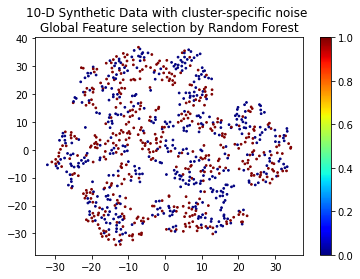

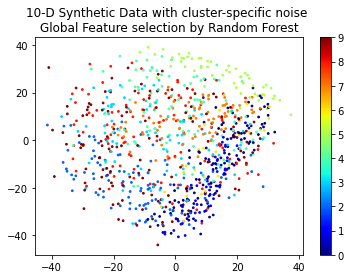

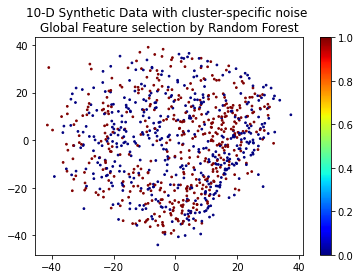

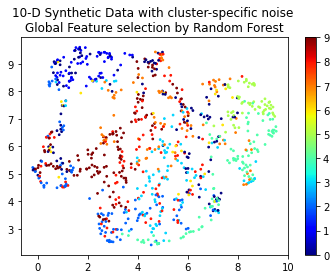

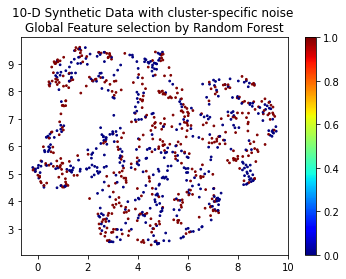

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf=ExtraTreesClassifier(n_estimators=499, bootstrap=True, oob_score=True, class_weight="balanced_subsample")
clf=clf.fit(X_train, y_train)
model=SelectFromModel(clf, prefit=True)
retain_ind2=np.where(model.get_support())[0]

from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
dr=TSNE(n_components=2)
np.random.seed(123)
out=dr.fit_transform(X_train[:,retain_ind2])

#Plot by cluster
fig=plot_reduced_dimension(out, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nGlobal Feature selection by Random Forest", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_RFfeatureSelect_cluster_tSNE"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(out, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nGlobal Feature selection by Random Forest", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_RFfeatureSelect_class_tSNE"
                                                 )
                          )

from scipy.spatial.distance import pdist, squareform
import ivis
n_neighbors=15
Dmat=pdist(X_train[:,retain_ind2], metric='euclidean')
neighbour_matrix=np.argsort(squareform(Dmat), axis=1)[:,:n_neighbors]

ivis_model=ivis.Ivis(k=n_neighbors, embedding_dims=2, 
          model='maaten', neighbour_matrix=neighbour_matrix, verbose=1)
ivis_model.fit(X_train[:, retain_ind2])

ivis_embedding=ivis_model.transform(X_train[:, retain_ind2])

#Plot by cluster
fig=plot_reduced_dimension(ivis_embedding, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nGlobal Feature selection by Random Forest", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_RFfeatureSelect_cluster_ivis"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(ivis_embedding, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nGlobal Feature selection by Random Forest", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_RFfeatureSelect_class_ivis"
                                                 )
                          )

import umap
n_neighbors=15

reducer=umap.UMAP(metric='euclidean', n_neighbors=n_neighbors)
umap_embedding=reducer.fit_transform(X_train[:, retain_ind2])

#Plot by cluster
fig=plot_reduced_dimension(umap_embedding, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nGlobal Feature selection by Random Forest", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_RFfeatureSelect_cluster_umap"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(umap_embedding, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nGlobal Feature selection by Random Forest", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_RFfeatureSelect_class_umap"
                                                 )
                          )

In [30]:
from algorithms import COSA
from importlib import reload
reload(COSA)
cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, n_iter=20,
                                distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=-1
                    )
cosa_mdl.fit(X_train)
Fweights=cosa_mdl.output_Fweight()
cosa_dist=cosa_mdl.output_Dmat()


Starting on outer iteration 1; beta/eta:0.220
Wchange:0.839, Crit:-125.683
Wchange:0.479, Crit:-129.966
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:0.234, Crit:-147.099
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:0.130, Crit:-151.773
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 4; beta/eta:0.280
Wchange:0.081, Crit:-153.391
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 5; beta/eta:0.300
Wchange:0.053, Crit:-153.431
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 6; beta/eta:0.320
Wchange:0.039, Crit:-152.908
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 7; beta/eta:0.340
Wchange:0.031, Crit:-152.322
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 8; beta/eta:0.360
Wchange:0.022, Crit:-151.893
Inner loop converged 

In [31]:
cosa_mdl.fit_OOS(X_test)

Starting on outer iteration 1; beta/eta:0.220
Wchange:890.297, Crit:-7.812
Wchange:451.365, Crit:-21.890
Wchange:184.894, Crit:-18.211
Wchange:89.120, Crit:-17.268
Wchange:31.963, Crit:-17.033
Wchange:17.211, Crit:-16.840
Wchange:13.141, Crit:-16.759
Wchange:5.030, Crit:-16.707
Wchange:3.129, Crit:-16.702
Wchange:0.000, Crit:-16.693
Inner loop converged in (or maxed out) at 10 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:9.600, Crit:-16.467
Wchange:1.557, Crit:-16.538
Wchange:0.590, Crit:-16.556
Wchange:0.590, Crit:-16.546
Wchange:0.590, Crit:-16.556
Wchange:0.590, Crit:-16.546
Wchange:0.590, Crit:-16.556
Wchange:0.590, Crit:-16.546
Wchange:0.590, Crit:-16.556
Wchange:0.590, Crit:-16.546
Inner loop converged in (or maxed out) at 10 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:7.156, Crit:-16.348
Wchange:7.089, Crit:-16.373
Wchange:4.365, Crit:-16.409
Wchange:0.896, Crit:-16.436
Wchange:0.896, Crit:-16.422
Wchange:0.896, Crit:-16.436
Wchange:0.896, Crit:-16

In [32]:
Fweights_test=cosa_mdl.output_Fweight(OOS=True)
cosa_dist_test=cosa_mdl.output_Dmat(OOS=True)

In [46]:
#Save Fweights

df=pd.DataFrame(Fweights)
df.to_csv(os.path.join(SynthDataFolder, "Fweights.csv"), index=False)
df=pd.DataFrame(Fweights_test)
df.to_csv(os.path.join(SynthDataFolder, "Fweights_test.csv"), index=False)
df=pd.DataFrame(cosa_dist)
df.to_csv(os.path.join(SynthDataFolder, "cosa_dist.csv"), index=False)
df=pd.DataFrame(cosa_dist_test)
df.to_csv(os.path.join(SynthDataFolder, "cosa_dist_test.csv"), index=False)

Training neural network
Epoch 1/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.8060
Epoch 2/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.9614
Epoch 3/1000
8/8 [==============================] - 0s 17ms/step - loss: 2.4512
Epoch 4/1000
8/8 [==============================] - 0s 16ms/step - loss: 2.6663
Epoch 5/1000
8/8 [==============================] - 0s 16ms/step - loss: 2.6630
Epoch 6/1000
8/8 [==============================] - 0s 16ms/step - loss: 2.2071
Epoch 7/1000
8/8 [==============================] - 0s 16ms/step - loss: 2.1425
Epoch 8/1000
8/8 [==============================] - 0s 16ms/step - loss: 2.1329
Epoch 9/1000
8/8 [==============================] - 0s 16ms/step - loss: 2.8317
Epoch 10/1000
8/8 [==============================] - 0s 16ms/step - loss: 2.3012
Epoch 11/1000
8/8 [==============================] - 0s 18ms/step - loss: 2.3282
Epoch 12/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.8645
Epoch 13/1000

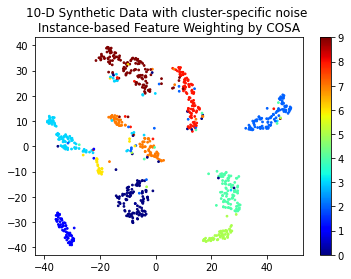

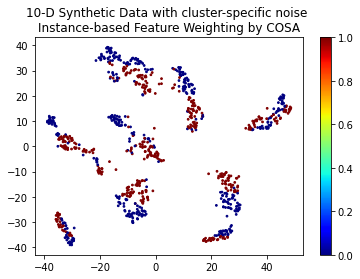

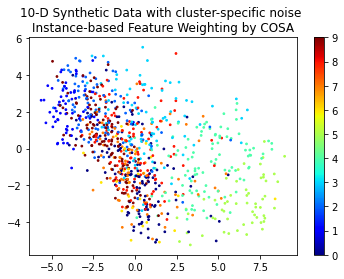

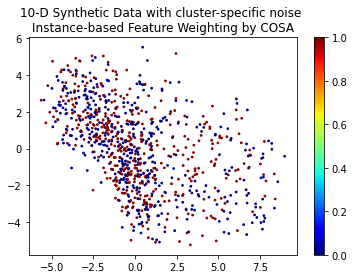

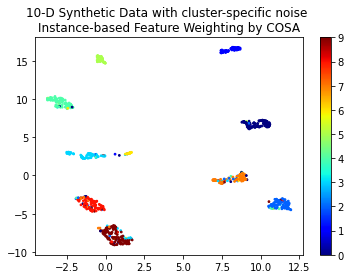

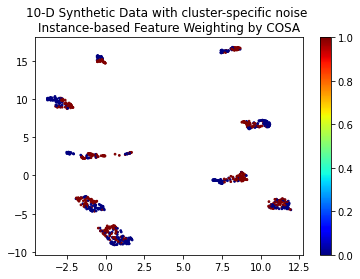

In [49]:

from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
dr=TSNE(n_components=2, metric="precomputed")
np.random.seed(123)
out=dr.fit_transform(cosa_dist)


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

#Plot by cluster
fig=plot_reduced_dimension(out, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nInstance-based Feature Weighting by COSA", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_COSAFeatureWeighting_cluster_ivis"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(out, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nInstance-based Feature Weighting by COSA", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_COSAFeatureWeighting_class_ivis"
                                                 )
                          )

from scipy.spatial.distance import pdist, squareform
import ivis
n_neighbors=15
Dmat=cosa_dist
neighbour_matrix=np.argsort(Dmat, axis=1)[:,:n_neighbors]

ivis_model=ivis.Ivis(k=n_neighbors, embedding_dims=2, 
          model='maaten', neighbour_matrix=neighbour_matrix, verbose=1)
ivis_model.fit(X_train)

ivis_embedding=ivis_model.transform(X_train)

#Plot by cluster
fig=plot_reduced_dimension(ivis_embedding, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nInstance-based Feature Weighting by COSA", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_COSAFeatureWeighting_cluster_ivis"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(ivis_embedding, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nInstance-based Feature Weighting by COSA", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_COSAFeatureWeighting_class_ivis"
                                                 )
                          )

import umap
n_neighbors=15

reducer=umap.UMAP(metric='euclidean', n_neighbors=n_neighbors)
umap_embedding=reducer.fit_transform(cosa_dist)

#Plot by cluster
fig=plot_reduced_dimension(umap_embedding, cluster_labels_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nInstance-based Feature Weighting by COSA", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_COSAFeatureWeighting_cluster_umap"
                                                 )
                          )

#Plot by label
fig=plot_reduced_dimension(umap_embedding, y_train, 
                           title="10-D Synthetic Data with cluster-specific noise \nInstance-based Feature Weighting by COSA", 
                           save_file=os.path.join(SynthDataFolder, 
                                                  "SynthData_10dim_clusternoise_COSAFeatureWeighting_class_umap"
                                                 )
                          )

<BarContainer object of 10 artists>

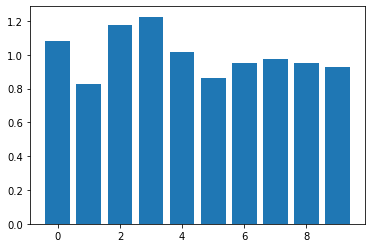

In [50]:
plt.bar(range(n_dim), clf.feature_importances_*n_dim)

<BarContainer object of 10 artists>

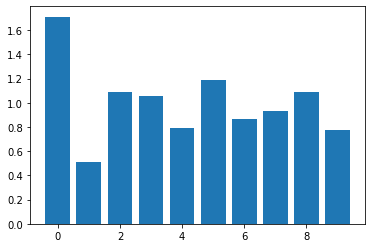

In [51]:
plt.bar(range(n_dim), np.average(Fweights, axis=0))

In [37]:
np.percentile(Fweights, 90, axis=0)

array([3.54343652, 3.13764109, 3.46293329, 3.08774888, 2.8778376 ,
       3.59051402, 3.08840257, 3.42844654, 3.19716538, 3.29686394])

<BarContainer object of 10 artists>

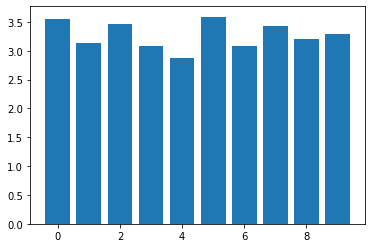

In [38]:
plt.bar(range(n_dim), np.percentile(Fweights, 90, axis=0))

In [52]:
all_noise_features

[array([0, 1, 3, 4, 5, 7, 8]),
 array([1, 3, 4, 6, 7, 8, 9]),
 array([0, 2, 3, 6, 7, 8, 9]),
 array([0, 1, 2, 4, 5, 6, 8]),
 array([1, 2, 4, 5, 6, 7, 9]),
 array([1, 2, 3, 5, 6, 7, 9]),
 array([0, 1, 3, 4, 5, 8, 9]),
 array([0, 1, 3, 6, 7, 8, 9]),
 array([1, 2, 3, 4, 5, 8, 9]),
 array([1, 2, 4, 5, 6, 7, 9])]

In [56]:
noise_feature_counts=np.unique(all_noise_features, return_counts=True)[1]
print(f"Number of meaningful clusters per feature: {10-noise_feature_counts}")

from scipy.stats import pearsonr
out1=pearsonr(10-noise_feature_counts, clf.feature_importances_*n_dim)
print(f"Correlation between number of meaningful clusters per feature and learned feature weights by RF: \nR={out1[0]}, p={out1[1]}")
out2=pearsonr(10-noise_feature_counts,np.average(Fweights, axis=0))
print(f"Correlation between number of meaningful clusters per feature and learned feature weights by COSA: \nR={out2[0]}, p={out2[1]}")

Number of meaningful clusters per feature: [5 1 4 3 3 3 3 3 3 2]
Correlation between number of meaningful clusters per feature and learned feature weights by RF: 
R=0.6217360339662621, p=0.05497381643847518
Correlation between number of meaningful clusters per feature and learned feature weights by COSA: 
R=0.8955916691344565, p=0.0004575519948996324


COSA is 'better' at subspace clustering problem than RF

Text(0, 0.5, 'Learned feature importance')

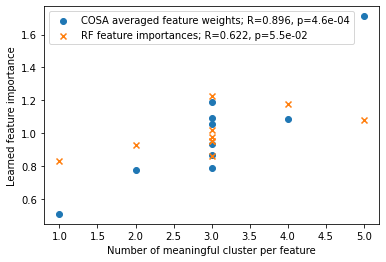

In [70]:
#Get default colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig,ax=plt.subplots()
ax.scatter(10-noise_feature_counts, np.average(Fweights, axis=0), c=colors[0],
           label=f"COSA averaged feature weights; R={out2[0]:.3f}, p={out2[1]:.1e}")
ax.scatter(10-noise_feature_counts, clf.feature_importances_*n_dim, c=colors[1],
           label=f"RF feature importances; R={out1[0]:.3f}, p={out1[1]:.1e}", marker="x")

ax.legend()
ax.set_xlabel("Number of meaningful cluster per feature")
ax.set_ylabel("Learned feature importance")

[0.09387299 0.01761882 0.03829252 0.03883584 0.04884575 0.0322766
 0.02575238 0.02808681 0.04123192 0.02768101]


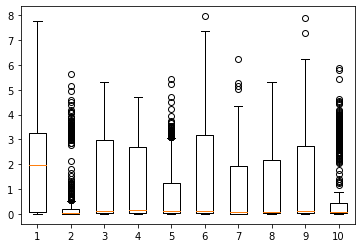

In [12]:
print(np.percentile(Fweights, 30, axis=0))
_=plt.boxplot(Fweights)

## Objective 2: Compare performance of RF and attention model

In [50]:
# Test Attention Model
# Copied on 22/12/20

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
n_feat=n_dim

n_batch=32

np.random.seed(123)

train_ds=tf.data.Dataset.from_tensor_slices((np.hstack([X_train,Fweights]),
                                             np.expand_dims(y_train, axis=1).astype(np.float32)
                                            ))
train_ds=train_ds.batch(n_batch)

val_ds=tf.data.Dataset.from_tensor_slices((np.hstack([X_test,Fweights_test]),
                                           np.expand_dims(y_test, axis=1).astype(np.float32)
                                          ))
val_ds=val_ds.batch(n_batch)

# test_ds=tf.data.Dataset.from_tensor_slices(((X_test, cosa_mdl.Fweight_OOS), 
#                                             y_test.astype(np.float32)
#                                            ))
# train_ds.element_spec
from tensorflow.keras import callbacks

# log_dir="training_SynthData10dim/" + "attention_modelwFW"
# tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


checkpoint_path = os.path.join("training_SynthData10dim",
                                "attention_modelwFW_chkpt")

try: 
    os.mkdir(checkpoint_path) 
except OSError as error: 
    print(error) 

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, LeakyReLU, Dense, Activation, ReLU
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.initializers import VarianceScaling, RandomNormal


n_attention = 10
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
#n_batch = 32 
momentum=0.8
learning_rate=0.01


from algorithms import attention_model

from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Activation

from tensorflow import nn

np.random.seed(0)

attention_model2=attention_model.AttentionModelwFeatWeights(
                     n_attention=n_attention, 
                     n_attention_hidden=n_attention_hidden, 
                     n_attention_out=n_attention_out,
                     n_feat=n_feat, 
                     n_concat_hidden=n_concat_hidden,
                     n_hidden1=n_hidden1,
                     #n_hidden2=n_hidden2,
                     activation=None,    
                     hidden_activation="selu",
                     concat_activation="selu",
                     #concat_activity_regularizer=None, 
#                      concat_activity_regularizer=l1(1E-5),
                     kernel_initializer=VarianceScaling(), 
                     kernel_regularizer=l2(1E-5),
                     bias_regularizer=l2(1E-5),
                     attention_initializer=VarianceScaling(), 
                     attention_hidden_activation="selu",
                     attention_output_activation=Activation("sigmoid",),
                 #loss='binary_crossentropy',
#                     loss = nn.sigmoid_cross_entropy_with_logits
                )
attention_model2.compile(optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.1),
                         #tf.optimizers.Adam(learning_rate=learning_rate,),
                         
                    #loss='binary_crossentropy',
                    loss = nn.sigmoid_cross_entropy_with_logits,
                    metrics=['accuracy'],
                    )

attention_model2.fit(train_ds, 
                    epochs=1,
                    #batch_size=n_batch,
                    validation_data=val_ds,
                    shuffle=True,
                    verbose=2
                   )

#Set feat weights
# Fweights=cosa_mdl.Fweight
sampled_Fweights=Fweights[np.random.choice(range(len(Fweights)), n_attention)]
for i in range(n_attention):
    weights=attention_model2.attentions.attention_layers[i].get_weights()
    weights[0]=np.reshape(sampled_Fweights[i], (1,n_feat))
    attention_model2.attentions.attention_layers[i].set_weights(weights)


n_epoch=1000
attention_model2.fit(train_ds, 
                    epochs=n_epoch,
                    #batch_size=n_batch,
                    validation_data=val_ds,
                    shuffle=True,
                    callbacks=[cp_callback,
                               csvlogger_callback
                              ],
                    verbose=2
                   )

29/29 - 1s - loss: 0.6755 - accuracy: 0.6144 - val_loss: 1.0962 - val_accuracy: 0.6000
Epoch 1/1000

Epoch 00001: val_accuracy improved from -inf to 0.63000, saving model to training_SynthData10dim\attention_modelwFW_chkpt
29/29 - 0s - loss: 0.5700 - accuracy: 0.6889 - val_loss: 0.8333 - val_accuracy: 0.6300
Epoch 2/1000

Epoch 00002: val_accuracy improved from 0.63000 to 0.67000, saving model to training_SynthData10dim\attention_modelwFW_chkpt
29/29 - 0s - loss: 0.5153 - accuracy: 0.7389 - val_loss: 0.7771 - val_accuracy: 0.6700
Epoch 3/1000

Epoch 00003: val_accuracy improved from 0.67000 to 0.69000, saving model to training_SynthData10dim\attention_modelwFW_chkpt
29/29 - 0s - loss: 0.4879 - accuracy: 0.7556 - val_loss: 0.7336 - val_accuracy: 0.6900
Epoch 4/1000

Epoch 00004: val_accuracy did not improve from 0.69000
29/29 - 0s - loss: 0.4671 - accuracy: 0.7689 - val_loss: 0.7025 - val_accuracy: 0.6900
Epoch 5/1000

Epoch 00005: val_accuracy improved from 0.69000 to 0.71000, saving m

Epoch 00099: val_accuracy did not improve from 0.84000
29/29 - 0s - loss: 0.1166 - accuracy: 0.9556 - val_loss: 0.6447 - val_accuracy: 0.8000
Epoch 100/1000

Epoch 00100: val_accuracy did not improve from 0.84000
29/29 - 0s - loss: 0.1078 - accuracy: 0.9644 - val_loss: 0.6626 - val_accuracy: 0.7900
Epoch 101/1000

Epoch 00101: val_accuracy did not improve from 0.84000
29/29 - 0s - loss: 0.1083 - accuracy: 0.9622 - val_loss: 0.6657 - val_accuracy: 0.8000
Epoch 102/1000

Epoch 00102: val_accuracy did not improve from 0.84000
29/29 - 0s - loss: 0.1093 - accuracy: 0.9611 - val_loss: 0.6759 - val_accuracy: 0.7900
Epoch 103/1000

Epoch 00103: val_accuracy did not improve from 0.84000
29/29 - 0s - loss: 0.1059 - accuracy: 0.9611 - val_loss: 0.7455 - val_accuracy: 0.7800
Epoch 104/1000

Epoch 00104: val_accuracy did not improve from 0.84000
29/29 - 0s - loss: 0.1122 - accuracy: 0.9567 - val_loss: 0.6784 - val_accuracy: 0.8100
Epoch 105/1000

Epoch 00105: val_accuracy did not improve from 0.840


Epoch 00150: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0526 - accuracy: 0.9856 - val_loss: 0.8562 - val_accuracy: 0.8200
Epoch 151/1000

Epoch 00151: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0440 - accuracy: 0.9878 - val_loss: 0.8935 - val_accuracy: 0.8200
Epoch 152/1000

Epoch 00152: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0597 - accuracy: 0.9844 - val_loss: 0.8673 - val_accuracy: 0.8200
Epoch 153/1000

Epoch 00153: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0476 - accuracy: 0.9878 - val_loss: 0.8445 - val_accuracy: 0.8300
Epoch 154/1000

Epoch 00154: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0446 - accuracy: 0.9867 - val_loss: 0.8790 - val_accuracy: 0.8200
Epoch 155/1000

Epoch 00155: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0486 - accuracy: 0.9889 - val_loss: 0.8274 - val_accuracy: 0.8400
Epoch 156/1000

Epoch 00156: val_accuracy did not improve from 0.86

Epoch 202/1000

Epoch 00202: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0520 - accuracy: 0.9878 - val_loss: 1.1012 - val_accuracy: 0.8200
Epoch 203/1000

Epoch 00203: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0515 - accuracy: 0.9856 - val_loss: 1.0176 - val_accuracy: 0.8400
Epoch 204/1000

Epoch 00204: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0495 - accuracy: 0.9889 - val_loss: 1.1773 - val_accuracy: 0.8100
Epoch 205/1000

Epoch 00205: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0458 - accuracy: 0.9867 - val_loss: 0.9661 - val_accuracy: 0.8400
Epoch 206/1000

Epoch 00206: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0318 - accuracy: 0.9933 - val_loss: 1.0384 - val_accuracy: 0.8200
Epoch 207/1000

Epoch 00207: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.1139 - accuracy: 0.9711 - val_loss: 1.2516 - val_accuracy: 0.7900
Epoch 208/1000

Epoch 00208: val_accuracy did not im

Epoch 254/1000

Epoch 00254: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0132 - accuracy: 0.9967 - val_loss: 1.3028 - val_accuracy: 0.8200
Epoch 255/1000

Epoch 00255: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0109 - accuracy: 0.9989 - val_loss: 1.2876 - val_accuracy: 0.8200
Epoch 256/1000

Epoch 00256: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0102 - accuracy: 0.9989 - val_loss: 1.3023 - val_accuracy: 0.8200
Epoch 257/1000

Epoch 00257: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.3164 - val_accuracy: 0.8200
Epoch 258/1000

Epoch 00258: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 1.3283 - val_accuracy: 0.8200
Epoch 259/1000

Epoch 00259: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.3360 - val_accuracy: 0.8200
Epoch 260/1000

Epoch 00260: val_accuracy did not im

Epoch 306/1000

Epoch 00306: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0119 - accuracy: 0.9989 - val_loss: 1.3829 - val_accuracy: 0.8300
Epoch 307/1000

Epoch 00307: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0169 - accuracy: 0.9978 - val_loss: 1.3933 - val_accuracy: 0.8300
Epoch 308/1000

Epoch 00308: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0107 - accuracy: 0.9989 - val_loss: 1.4698 - val_accuracy: 0.8100
Epoch 309/1000

Epoch 00309: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0183 - accuracy: 0.9967 - val_loss: 1.3717 - val_accuracy: 0.8500
Epoch 310/1000

Epoch 00310: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 1.3870 - val_accuracy: 0.8500
Epoch 311/1000

Epoch 00311: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 1.3998 - val_accuracy: 0.8500
Epoch 312/1000

Epoch 00312: val_accuracy did not im

Epoch 358/1000

Epoch 00358: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 1.3880 - val_accuracy: 0.8400
Epoch 359/1000

Epoch 00359: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 1.3977 - val_accuracy: 0.8200
Epoch 360/1000

Epoch 00360: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0082 - accuracy: 1.0000 - val_loss: 1.4035 - val_accuracy: 0.8200
Epoch 361/1000

Epoch 00361: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.4148 - val_accuracy: 0.8300
Epoch 362/1000

Epoch 00362: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 1.4282 - val_accuracy: 0.8300
Epoch 363/1000

Epoch 00363: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0083 - accuracy: 0.9989 - val_loss: 1.4436 - val_accuracy: 0.8300
Epoch 364/1000

Epoch 00364: val_accuracy did not im

Epoch 410/1000

Epoch 00410: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 1.5019 - val_accuracy: 0.8300
Epoch 411/1000

Epoch 00411: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.5000 - val_accuracy: 0.8300
Epoch 412/1000

Epoch 00412: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.5012 - val_accuracy: 0.8300
Epoch 413/1000

Epoch 00413: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.5031 - val_accuracy: 0.8300
Epoch 414/1000

Epoch 00414: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.5044 - val_accuracy: 0.8300
Epoch 415/1000

Epoch 00415: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0106 - accuracy: 0.9978 - val_loss: 1.5736 - val_accuracy: 0.8200
Epoch 416/1000

Epoch 00416: val_accuracy did not im

Epoch 462/1000

Epoch 00462: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.5813 - val_accuracy: 0.8300
Epoch 463/1000

Epoch 00463: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.5864 - val_accuracy: 0.8300
Epoch 464/1000

Epoch 00464: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.5940 - val_accuracy: 0.8300
Epoch 465/1000

Epoch 00465: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.5940 - val_accuracy: 0.8300
Epoch 466/1000

Epoch 00466: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.5971 - val_accuracy: 0.8300
Epoch 467/1000

Epoch 00467: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.6015 - val_accuracy: 0.8300
Epoch 468/1000

Epoch 00468: val_accuracy did not im

Epoch 514/1000

Epoch 00514: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.7411 - val_accuracy: 0.8300
Epoch 515/1000

Epoch 00515: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.7426 - val_accuracy: 0.8300
Epoch 516/1000

Epoch 00516: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.7442 - val_accuracy: 0.8200
Epoch 517/1000

Epoch 00517: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.7455 - val_accuracy: 0.8200
Epoch 518/1000

Epoch 00518: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.7468 - val_accuracy: 0.8200
Epoch 519/1000

Epoch 00519: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.7485 - val_accuracy: 0.8200
Epoch 520/1000

Epoch 00520: val_accuracy did not im

Epoch 566/1000

Epoch 00566: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.8120 - val_accuracy: 0.8200
Epoch 567/1000

Epoch 00567: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.8133 - val_accuracy: 0.8200
Epoch 568/1000

Epoch 00568: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.8145 - val_accuracy: 0.8200
Epoch 569/1000

Epoch 00569: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.8157 - val_accuracy: 0.8200
Epoch 570/1000

Epoch 00570: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.8168 - val_accuracy: 0.8200
Epoch 571/1000

Epoch 00571: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.8180 - val_accuracy: 0.8200
Epoch 572/1000

Epoch 00572: val_accuracy did not im

Epoch 618/1000

Epoch 00618: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.8677 - val_accuracy: 0.8200
Epoch 619/1000

Epoch 00619: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.8687 - val_accuracy: 0.8200
Epoch 620/1000

Epoch 00620: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.8697 - val_accuracy: 0.8200
Epoch 621/1000

Epoch 00621: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.8709 - val_accuracy: 0.8200
Epoch 622/1000

Epoch 00622: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.8717 - val_accuracy: 0.8200
Epoch 623/1000

Epoch 00623: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.8727 - val_accuracy: 0.8200
Epoch 624/1000

Epoch 00624: val_accuracy did not im

Epoch 670/1000

Epoch 00670: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.9128 - val_accuracy: 0.8200
Epoch 671/1000

Epoch 00671: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.9136 - val_accuracy: 0.8200
Epoch 672/1000

Epoch 00672: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.9144 - val_accuracy: 0.8200
Epoch 673/1000

Epoch 00673: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.9152 - val_accuracy: 0.8200
Epoch 674/1000

Epoch 00674: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.9158 - val_accuracy: 0.8200
Epoch 675/1000

Epoch 00675: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.9167 - val_accuracy: 0.8200
Epoch 676/1000

Epoch 00676: val_accuracy did not im

Epoch 722/1000

Epoch 00722: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9499 - val_accuracy: 0.8200
Epoch 723/1000

Epoch 00723: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9507 - val_accuracy: 0.8200
Epoch 724/1000

Epoch 00724: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9512 - val_accuracy: 0.8200
Epoch 725/1000

Epoch 00725: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9519 - val_accuracy: 0.8200
Epoch 726/1000

Epoch 00726: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9527 - val_accuracy: 0.8200
Epoch 727/1000

Epoch 00727: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9533 - val_accuracy: 0.8200
Epoch 728/1000

Epoch 00728: val_accuracy did not im

Epoch 774/1000

Epoch 00774: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9816 - val_accuracy: 0.8200
Epoch 775/1000

Epoch 00775: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9822 - val_accuracy: 0.8200
Epoch 776/1000

Epoch 00776: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9828 - val_accuracy: 0.8200
Epoch 777/1000

Epoch 00777: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9834 - val_accuracy: 0.8200
Epoch 778/1000

Epoch 00778: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9839 - val_accuracy: 0.8200
Epoch 779/1000

Epoch 00779: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.9845 - val_accuracy: 0.8200
Epoch 780/1000

Epoch 00780: val_accuracy did not im

Epoch 826/1000

Epoch 00826: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0092 - val_accuracy: 0.8200
Epoch 827/1000

Epoch 00827: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0097 - val_accuracy: 0.8200
Epoch 828/1000

Epoch 00828: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0102 - val_accuracy: 0.8200
Epoch 829/1000

Epoch 00829: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0107 - val_accuracy: 0.8200
Epoch 830/1000

Epoch 00830: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0112 - val_accuracy: 0.8200
Epoch 831/1000

Epoch 00831: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0117 - val_accuracy: 0.8200
Epoch 832/1000

Epoch 00832: val_accuracy did not im

Epoch 878/1000

Epoch 00878: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0331 - val_accuracy: 0.8200
Epoch 879/1000

Epoch 00879: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0335 - val_accuracy: 0.8200
Epoch 880/1000

Epoch 00880: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0339 - val_accuracy: 0.8200
Epoch 881/1000

Epoch 00881: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0344 - val_accuracy: 0.8200
Epoch 882/1000

Epoch 00882: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0349 - val_accuracy: 0.8200
Epoch 883/1000

Epoch 00883: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0353 - val_accuracy: 0.8200
Epoch 884/1000

Epoch 00884: val_accuracy did not im

Epoch 930/1000

Epoch 00930: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0541 - val_accuracy: 0.8200
Epoch 931/1000

Epoch 00931: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0544 - val_accuracy: 0.8200
Epoch 932/1000

Epoch 00932: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0548 - val_accuracy: 0.8200
Epoch 933/1000

Epoch 00933: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0551 - val_accuracy: 0.8200
Epoch 934/1000

Epoch 00934: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0554 - val_accuracy: 0.8200
Epoch 935/1000

Epoch 00935: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.0560 - val_accuracy: 0.8200
Epoch 936/1000

Epoch 00936: val_accuracy did not im

Epoch 982/1000

Epoch 00982: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.0729 - val_accuracy: 0.8200
Epoch 983/1000

Epoch 00983: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.0733 - val_accuracy: 0.8200
Epoch 984/1000

Epoch 00984: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.0736 - val_accuracy: 0.8200
Epoch 985/1000

Epoch 00985: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.0740 - val_accuracy: 0.8200
Epoch 986/1000

Epoch 00986: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.0743 - val_accuracy: 0.8200
Epoch 987/1000

Epoch 00987: val_accuracy did not improve from 0.86000
29/29 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 2.0746 - val_accuracy: 0.8200
Epoch 988/1000

Epoch 00988: val_accuracy did not im

In [51]:
import datetime
from tensorflow.keras import callbacks
# log_dir="training_SynthData10dim/" + "attention_modelwoFW"
# tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = os.path.join("training_SynthData10dim",
                                "attention_modelwoFW_chkpt")

try: 
    os.mkdir(checkpoint_path) 
except OSError as error: 
    print(error) 

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)



# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

np.random.seed(0)

attention_model3=attention_model.AttentionModel(
                     n_attention=n_attention, 
                     n_attention_hidden=n_attention_hidden, 
                     n_attention_out=n_attention_out,
                     n_feat=n_feat, 
                     n_concat_hidden=n_concat_hidden,
                     n_hidden1=n_hidden1,
                     #n_hidden2=n_hidden2,
                     activation=None,    
                     hidden_activation="selu",
                     concat_activation="selu",
                     #concat_activity_regularizer=None, 
#                      concat_activity_regularizer=l1(1E-5),
                     kernel_initializer=VarianceScaling(), 
                     kernel_regularizer=l2(1E-5),
                     bias_regularizer=l2(1E-5),
                     attention_initializer=VarianceScaling(), 
                     attention_hidden_activation="selu",
                     attention_output_activation=Activation("sigmoid",),
                 #loss='binary_crossentropy',
#                     loss = nn.sigmoid_cross_entropy_with_logits
                )

attention_model3.compile(optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.1),
                         #tf.optimizers.Adam(learning_rate=learning_rate,),
                         
                    #loss='binary_crossentropy',
                    loss = nn.sigmoid_cross_entropy_with_logits,
                    metrics=['accuracy'],
                    )

n_epoch=1000
attention_model3.fit(X_train,
                     np.expand_dims(y_train, axis=1).astype(np.float32),
                    epochs=n_epoch,
                    #batch_size=n_batch,
                    validation_data=(X_test, np.expand_dims(y_test, axis=1).astype(np.float32)),
                    shuffle=True,
                    callbacks=[cp_callback,
                               csvlogger_callback
                              ],
                    verbose=2
                   )

Epoch 1/1000

Epoch 00001: val_accuracy improved from -inf to 0.41000, saving model to training_SynthData10dim\attention_modelwoFW_chkpt
29/29 - 0s - loss: 0.7627 - accuracy: 0.4978 - val_loss: 1.1078 - val_accuracy: 0.4100
Epoch 2/1000

Epoch 00002: val_accuracy did not improve from 0.41000
29/29 - 0s - loss: 0.7095 - accuracy: 0.5344 - val_loss: 0.9204 - val_accuracy: 0.4100
Epoch 3/1000

Epoch 00003: val_accuracy improved from 0.41000 to 0.46000, saving model to training_SynthData10dim\attention_modelwoFW_chkpt
29/29 - 0s - loss: 0.6782 - accuracy: 0.5522 - val_loss: 0.8591 - val_accuracy: 0.4600
Epoch 4/1000

Epoch 00004: val_accuracy improved from 0.46000 to 0.48000, saving model to training_SynthData10dim\attention_modelwoFW_chkpt
29/29 - 0s - loss: 0.6541 - accuracy: 0.5622 - val_loss: 0.9024 - val_accuracy: 0.4800
Epoch 5/1000

Epoch 00005: val_accuracy did not improve from 0.48000
29/29 - 0s - loss: 0.6519 - accuracy: 0.5967 - val_loss: 0.8215 - val_accuracy: 0.4800
Epoch 6/10

Epoch 00100: val_accuracy improved from 0.69000 to 0.71000, saving model to training_SynthData10dim\attention_modelwoFW_chkpt
29/29 - 0s - loss: 0.0109 - accuracy: 1.0000 - val_loss: 1.5488 - val_accuracy: 0.7100
Epoch 101/1000

Epoch 00101: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0123 - accuracy: 1.0000 - val_loss: 1.5751 - val_accuracy: 0.6600
Epoch 102/1000

Epoch 00102: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 1.6784 - val_accuracy: 0.6500
Epoch 103/1000

Epoch 00103: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0106 - accuracy: 1.0000 - val_loss: 1.5818 - val_accuracy: 0.6600
Epoch 104/1000

Epoch 00104: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.5157 - val_accuracy: 0.7000
Epoch 105/1000

Epoch 00105: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0132 - accuracy: 0.9989 - val_loss: 1.6431 - val_accuracy: 0.66

Epoch 152/1000

Epoch 00152: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.9124 - val_accuracy: 0.6600
Epoch 153/1000

Epoch 00153: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.9486 - val_accuracy: 0.6600
Epoch 154/1000

Epoch 00154: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.9362 - val_accuracy: 0.6600
Epoch 155/1000

Epoch 00155: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.9320 - val_accuracy: 0.6600
Epoch 156/1000

Epoch 00156: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.9456 - val_accuracy: 0.6600
Epoch 157/1000

Epoch 00157: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.9582 - val_accuracy: 0.6600
Epoch 158/1000

Epoch 00158: val_accuracy did not im

Epoch 204/1000

Epoch 00204: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.0996 - val_accuracy: 0.6700
Epoch 205/1000

Epoch 00205: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.1027 - val_accuracy: 0.6600
Epoch 206/1000

Epoch 00206: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.1045 - val_accuracy: 0.6700
Epoch 207/1000

Epoch 00207: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.1138 - val_accuracy: 0.6700
Epoch 208/1000

Epoch 00208: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.1125 - val_accuracy: 0.6700
Epoch 209/1000

Epoch 00209: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 2.1174 - val_accuracy: 0.6700
Epoch 210/1000

Epoch 00210: val_accuracy did not im

Epoch 256/1000

Epoch 00256: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.2211 - val_accuracy: 0.6700
Epoch 257/1000

Epoch 00257: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.2246 - val_accuracy: 0.6700
Epoch 258/1000

Epoch 00258: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.2232 - val_accuracy: 0.6700
Epoch 259/1000

Epoch 00259: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.2238 - val_accuracy: 0.6700
Epoch 260/1000

Epoch 00260: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.2276 - val_accuracy: 0.6700
Epoch 261/1000

Epoch 00261: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.2346 - val_accuracy: 0.6700
Epoch 262/1000

Epoch 00262: val_accuracy did not im

Epoch 308/1000

Epoch 00308: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.3144 - val_accuracy: 0.6700
Epoch 309/1000

Epoch 00309: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.3163 - val_accuracy: 0.6700
Epoch 310/1000

Epoch 00310: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.3246 - val_accuracy: 0.6700
Epoch 311/1000

Epoch 00311: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.3258 - val_accuracy: 0.6700
Epoch 312/1000

Epoch 00312: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.3272 - val_accuracy: 0.6700
Epoch 313/1000

Epoch 00313: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 2.3158 - val_accuracy: 0.6700
Epoch 314/1000

Epoch 00314: val_accuracy did not im

Epoch 360/1000

Epoch 00360: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.3846 - val_accuracy: 0.6600
Epoch 361/1000

Epoch 00361: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.3847 - val_accuracy: 0.6600
Epoch 362/1000

Epoch 00362: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.3873 - val_accuracy: 0.6600
Epoch 363/1000

Epoch 00363: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.3850 - val_accuracy: 0.6600
Epoch 364/1000

Epoch 00364: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.3857 - val_accuracy: 0.6700
Epoch 365/1000

Epoch 00365: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.3913 - val_accuracy: 0.6700
Epoch 366/1000

Epoch 00366: val_accuracy did not im

Epoch 412/1000

Epoch 00412: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.4353 - val_accuracy: 0.6700
Epoch 413/1000

Epoch 00413: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.4363 - val_accuracy: 0.6700
Epoch 414/1000

Epoch 00414: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.4391 - val_accuracy: 0.6700
Epoch 415/1000

Epoch 00415: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.4406 - val_accuracy: 0.6700
Epoch 416/1000

Epoch 00416: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.4448 - val_accuracy: 0.6700
Epoch 417/1000

Epoch 00417: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.4358 - val_accuracy: 0.6700
Epoch 418/1000

Epoch 00418: val_accuracy did not im

Epoch 464/1000

Epoch 00464: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.4877 - val_accuracy: 0.6600
Epoch 465/1000

Epoch 00465: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.4877 - val_accuracy: 0.6600
Epoch 466/1000

Epoch 00466: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.4889 - val_accuracy: 0.6600
Epoch 467/1000

Epoch 00467: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.4897 - val_accuracy: 0.6600
Epoch 468/1000

Epoch 00468: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.4900 - val_accuracy: 0.6600
Epoch 469/1000

Epoch 00469: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.4904 - val_accuracy: 0.6600
Epoch 470/1000

Epoch 00470: val_accuracy did not im

Epoch 516/1000

Epoch 00516: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5244 - val_accuracy: 0.6600
Epoch 517/1000

Epoch 00517: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5242 - val_accuracy: 0.6600
Epoch 518/1000

Epoch 00518: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5289 - val_accuracy: 0.6600
Epoch 519/1000

Epoch 00519: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5260 - val_accuracy: 0.6600
Epoch 520/1000

Epoch 00520: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5272 - val_accuracy: 0.6600
Epoch 521/1000

Epoch 00521: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5286 - val_accuracy: 0.6600
Epoch 522/1000

Epoch 00522: val_accuracy did not im

Epoch 568/1000

Epoch 00568: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5653 - val_accuracy: 0.6600
Epoch 569/1000

Epoch 00569: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5676 - val_accuracy: 0.6600
Epoch 570/1000

Epoch 00570: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5678 - val_accuracy: 0.6600
Epoch 571/1000

Epoch 00571: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5680 - val_accuracy: 0.6600
Epoch 572/1000

Epoch 00572: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5643 - val_accuracy: 0.6600
Epoch 573/1000

Epoch 00573: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.5664 - val_accuracy: 0.6600
Epoch 574/1000

Epoch 00574: val_accuracy did not im

Epoch 620/1000

Epoch 00620: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.5951 - val_accuracy: 0.6600
Epoch 621/1000

Epoch 00621: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.5968 - val_accuracy: 0.6600
Epoch 622/1000

Epoch 00622: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.5991 - val_accuracy: 0.6600
Epoch 623/1000

Epoch 00623: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.5981 - val_accuracy: 0.6600
Epoch 624/1000

Epoch 00624: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.5993 - val_accuracy: 0.6600
Epoch 625/1000

Epoch 00625: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6003 - val_accuracy: 0.6600
Epoch 626/1000

Epoch 00626: val_accuracy did not im

Epoch 672/1000

Epoch 00672: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6294 - val_accuracy: 0.6600
Epoch 673/1000

Epoch 00673: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6288 - val_accuracy: 0.6600
Epoch 674/1000

Epoch 00674: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6311 - val_accuracy: 0.6600
Epoch 675/1000

Epoch 00675: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6321 - val_accuracy: 0.6600
Epoch 676/1000

Epoch 00676: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6326 - val_accuracy: 0.6600
Epoch 677/1000

Epoch 00677: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6327 - val_accuracy: 0.6600
Epoch 678/1000

Epoch 00678: val_accuracy did not im

Epoch 724/1000

Epoch 00724: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6575 - val_accuracy: 0.6600
Epoch 725/1000

Epoch 00725: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6581 - val_accuracy: 0.6600
Epoch 726/1000

Epoch 00726: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6565 - val_accuracy: 0.6600
Epoch 727/1000

Epoch 00727: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6572 - val_accuracy: 0.6600
Epoch 728/1000

Epoch 00728: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6593 - val_accuracy: 0.6600
Epoch 729/1000

Epoch 00729: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.6587 - val_accuracy: 0.6600
Epoch 730/1000

Epoch 00730: val_accuracy did not im

Epoch 776/1000

Epoch 00776: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.6809 - val_accuracy: 0.6600
Epoch 777/1000

Epoch 00777: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.6779 - val_accuracy: 0.6600
Epoch 778/1000

Epoch 00778: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.6763 - val_accuracy: 0.6600
Epoch 779/1000

Epoch 00779: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.6750 - val_accuracy: 0.6600
Epoch 780/1000

Epoch 00780: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.6764 - val_accuracy: 0.6600
Epoch 781/1000

Epoch 00781: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.6757 - val_accuracy: 0.6600
Epoch 782/1000

Epoch 00782: val_accuracy did not im

Epoch 828/1000

Epoch 00828: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7050 - val_accuracy: 0.6700
Epoch 829/1000

Epoch 00829: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7044 - val_accuracy: 0.6700
Epoch 830/1000

Epoch 00830: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7043 - val_accuracy: 0.6700
Epoch 831/1000

Epoch 00831: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7050 - val_accuracy: 0.6700
Epoch 832/1000

Epoch 00832: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7044 - val_accuracy: 0.6700
Epoch 833/1000

Epoch 00833: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7054 - val_accuracy: 0.6700
Epoch 834/1000

Epoch 00834: val_accuracy did not im

Epoch 880/1000

Epoch 00880: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7212 - val_accuracy: 0.6600
Epoch 881/1000

Epoch 00881: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7198 - val_accuracy: 0.6600
Epoch 882/1000

Epoch 00882: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7215 - val_accuracy: 0.6600
Epoch 883/1000

Epoch 00883: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7239 - val_accuracy: 0.6600
Epoch 884/1000

Epoch 00884: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7238 - val_accuracy: 0.6700
Epoch 885/1000

Epoch 00885: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7250 - val_accuracy: 0.6700
Epoch 886/1000

Epoch 00886: val_accuracy did not im

Epoch 932/1000

Epoch 00932: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7422 - val_accuracy: 0.6700
Epoch 933/1000

Epoch 00933: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7422 - val_accuracy: 0.6700
Epoch 934/1000

Epoch 00934: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7435 - val_accuracy: 0.6700
Epoch 935/1000

Epoch 00935: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7438 - val_accuracy: 0.6700
Epoch 936/1000

Epoch 00936: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7440 - val_accuracy: 0.6700
Epoch 937/1000

Epoch 00937: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7445 - val_accuracy: 0.6700
Epoch 938/1000

Epoch 00938: val_accuracy did not im

Epoch 984/1000

Epoch 00984: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7630 - val_accuracy: 0.6800
Epoch 985/1000

Epoch 00985: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7631 - val_accuracy: 0.6800
Epoch 986/1000

Epoch 00986: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7638 - val_accuracy: 0.6800
Epoch 987/1000

Epoch 00987: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7646 - val_accuracy: 0.6800
Epoch 988/1000

Epoch 00988: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7650 - val_accuracy: 0.6800
Epoch 989/1000

Epoch 00989: val_accuracy did not improve from 0.71000
29/29 - 0s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.7640 - val_accuracy: 0.6800
Epoch 990/1000

Epoch 00990: val_accuracy did not im

In [54]:
import datetime
from tensorflow.keras import callbacks
# log_dir="training_SynthData10dim/" + "denseModel"
# tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = os.path.join("training_SynthData10dim",
                                "denseModel")
try: 
    os.mkdir(checkpoint_path) 
except OSError as error: 
    print(error) 

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)


np.random.seed(0)

dense_model=Sequential()
# dense_model.add(Dense(n_attention*n_attention_hidden, 
#                  input_shape=(n_feat,),
#                 ))
dense_model.add(Dense(n_attention*n_feat, activation="selu",
                      kernel_initializer=VarianceScaling(),
                      kernel_regularizer=l2(1E-5),
                      bias_regularizer=l2(1E-5),
#                       activity_regularizer=l1(1E-5)
                     ))
dense_model.add(Dense(n_concat_hidden, activation="selu",
                      kernel_initializer=VarianceScaling(),
                      kernel_regularizer=l2(1E-5),
                      bias_regularizer=l2(1E-5),                      
                     ))
dense_model.add(Dense(n_hidden1))
dense_model.add(Dense(1))

dense_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.1),
              loss=nn.sigmoid_cross_entropy_with_logits,
              metrics=['accuracy'],
              )
n_epoch=1000

dense_model.fit(X_train, y_train.astype(np.float32), 
           epochs=n_epoch, batch_size=n_batch, 
           validation_data=(X_test, y_test.astype(np.float32)),
           verbose=2,
               callbacks=[cp_callback,
                          csvlogger_callback
                         ])

Epoch 1/1000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to training_SynthData10dim\denseModel
29/29 - 0s - loss: 0.8867 - accuracy: 0.4844 - val_loss: 0.8331 - val_accuracy: 0.5000
Epoch 2/1000

Epoch 00002: val_accuracy did not improve from 0.50000
29/29 - 0s - loss: 0.7307 - accuracy: 0.5167 - val_loss: 0.8398 - val_accuracy: 0.5000
Epoch 3/1000

Epoch 00003: val_accuracy improved from 0.50000 to 0.64000, saving model to training_SynthData10dim\denseModel
29/29 - 0s - loss: 0.7001 - accuracy: 0.5278 - val_loss: 0.6538 - val_accuracy: 0.6400
Epoch 4/1000

Epoch 00004: val_accuracy did not improve from 0.64000
29/29 - 0s - loss: 0.6947 - accuracy: 0.5278 - val_loss: 0.8840 - val_accuracy: 0.5200
Epoch 5/1000

Epoch 00005: val_accuracy did not improve from 0.64000
29/29 - 0s - loss: 0.6982 - accuracy: 0.5167 - val_loss: 0.7028 - val_accuracy: 0.5400
Epoch 6/1000

Epoch 00006: val_accuracy did not improve from 0.64000
29/29 - 0s - loss: 0.6832 - accuracy: 0.54

Epoch 102/1000

Epoch 00102: val_accuracy did not improve from 0.72000
29/29 - 0s - loss: 0.3411 - accuracy: 0.8511 - val_loss: 1.0489 - val_accuracy: 0.6800
Epoch 103/1000

Epoch 00103: val_accuracy did not improve from 0.72000
29/29 - 0s - loss: 0.3364 - accuracy: 0.8600 - val_loss: 1.6603 - val_accuracy: 0.5300
Epoch 104/1000

Epoch 00104: val_accuracy did not improve from 0.72000
29/29 - 0s - loss: 0.2977 - accuracy: 0.8867 - val_loss: 1.3715 - val_accuracy: 0.7000
Epoch 105/1000

Epoch 00105: val_accuracy did not improve from 0.72000
29/29 - 0s - loss: 0.3374 - accuracy: 0.8600 - val_loss: 1.1240 - val_accuracy: 0.6300
Epoch 106/1000

Epoch 00106: val_accuracy did not improve from 0.72000
29/29 - 0s - loss: 0.3029 - accuracy: 0.8622 - val_loss: 1.1908 - val_accuracy: 0.6500
Epoch 107/1000

Epoch 00107: val_accuracy did not improve from 0.72000
29/29 - 0s - loss: 0.3281 - accuracy: 0.8589 - val_loss: 1.5178 - val_accuracy: 0.5900
Epoch 108/1000

Epoch 00108: val_accuracy did not im

Epoch 154/1000

Epoch 00154: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.2575 - accuracy: 0.9011 - val_loss: 1.1467 - val_accuracy: 0.6500
Epoch 155/1000

Epoch 00155: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.2171 - accuracy: 0.9344 - val_loss: 1.1082 - val_accuracy: 0.6200
Epoch 156/1000

Epoch 00156: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.2053 - accuracy: 0.9311 - val_loss: 1.3407 - val_accuracy: 0.6200
Epoch 157/1000

Epoch 00157: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.1796 - accuracy: 0.9300 - val_loss: 4.6995 - val_accuracy: 0.4500
Epoch 158/1000

Epoch 00158: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.6062 - accuracy: 0.8467 - val_loss: 1.5932 - val_accuracy: 0.6300
Epoch 159/1000

Epoch 00159: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.2279 - accuracy: 0.9189 - val_loss: 1.3682 - val_accuracy: 0.6600
Epoch 160/1000

Epoch 00160: val_accuracy did not im

Epoch 206/1000

Epoch 00206: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.3089 - accuracy: 0.9111 - val_loss: 1.3387 - val_accuracy: 0.6700
Epoch 207/1000

Epoch 00207: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.1351 - accuracy: 0.9489 - val_loss: 2.4349 - val_accuracy: 0.5700
Epoch 208/1000

Epoch 00208: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.1915 - accuracy: 0.9378 - val_loss: 2.6072 - val_accuracy: 0.6500
Epoch 209/1000

Epoch 00209: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.2788 - accuracy: 0.9078 - val_loss: 1.4459 - val_accuracy: 0.6900
Epoch 210/1000

Epoch 00210: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.1361 - accuracy: 0.9522 - val_loss: 2.2763 - val_accuracy: 0.6300
Epoch 211/1000

Epoch 00211: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.2911 - accuracy: 0.9022 - val_loss: 1.6531 - val_accuracy: 0.5900
Epoch 212/1000

Epoch 00212: val_accuracy did not im

Epoch 258/1000

Epoch 00258: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0849 - accuracy: 0.9722 - val_loss: 2.2177 - val_accuracy: 0.6600
Epoch 259/1000

Epoch 00259: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0992 - accuracy: 0.9700 - val_loss: 2.2448 - val_accuracy: 0.6500
Epoch 260/1000

Epoch 00260: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0240 - accuracy: 0.9944 - val_loss: 2.4446 - val_accuracy: 0.6900
Epoch 261/1000

Epoch 00261: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0985 - accuracy: 0.9689 - val_loss: 2.3943 - val_accuracy: 0.6000
Epoch 262/1000

Epoch 00262: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0312 - accuracy: 0.9933 - val_loss: 2.3999 - val_accuracy: 0.6700
Epoch 263/1000

Epoch 00263: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0139 - accuracy: 1.0000 - val_loss: 2.6624 - val_accuracy: 0.6500
Epoch 264/1000

Epoch 00264: val_accuracy did not im

Epoch 310/1000

Epoch 00310: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 3.8301 - val_accuracy: 0.6200
Epoch 311/1000

Epoch 00311: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 3.8416 - val_accuracy: 0.6100
Epoch 312/1000

Epoch 00312: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 3.8471 - val_accuracy: 0.6100
Epoch 313/1000

Epoch 00313: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 3.8575 - val_accuracy: 0.6200
Epoch 314/1000

Epoch 00314: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 3.8716 - val_accuracy: 0.6100
Epoch 315/1000

Epoch 00315: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 3.8717 - val_accuracy: 0.6200
Epoch 316/1000

Epoch 00316: val_accuracy did not im

Epoch 362/1000

Epoch 00362: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 4.1975 - val_accuracy: 0.6400
Epoch 363/1000

Epoch 00363: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 4.2050 - val_accuracy: 0.6400
Epoch 364/1000

Epoch 00364: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.2091 - val_accuracy: 0.6400
Epoch 365/1000

Epoch 00365: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.2133 - val_accuracy: 0.6400
Epoch 366/1000

Epoch 00366: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.2175 - val_accuracy: 0.6400
Epoch 367/1000

Epoch 00367: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.2207 - val_accuracy: 0.6300
Epoch 368/1000

Epoch 00368: val_accuracy did not im

Epoch 414/1000

Epoch 00414: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.4033 - val_accuracy: 0.6400
Epoch 415/1000

Epoch 00415: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.4055 - val_accuracy: 0.6400
Epoch 416/1000

Epoch 00416: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.4075 - val_accuracy: 0.6400
Epoch 417/1000

Epoch 00417: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.4107 - val_accuracy: 0.6400
Epoch 418/1000

Epoch 00418: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.4134 - val_accuracy: 0.6400
Epoch 419/1000

Epoch 00419: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 4.4175 - val_accuracy: 0.6400
Epoch 420/1000

Epoch 00420: val_accuracy did not im

Epoch 466/1000

Epoch 00466: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.5419 - val_accuracy: 0.6400
Epoch 467/1000

Epoch 00467: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.5449 - val_accuracy: 0.6400
Epoch 468/1000

Epoch 00468: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.5466 - val_accuracy: 0.6400
Epoch 469/1000

Epoch 00469: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.5487 - val_accuracy: 0.6400
Epoch 470/1000

Epoch 00470: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.5500 - val_accuracy: 0.6400
Epoch 471/1000

Epoch 00471: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.5508 - val_accuracy: 0.6400
Epoch 472/1000

Epoch 00472: val_accuracy did not im

Epoch 518/1000

Epoch 00518: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.6432 - val_accuracy: 0.6400
Epoch 519/1000

Epoch 00519: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.6447 - val_accuracy: 0.6400
Epoch 520/1000

Epoch 00520: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.6461 - val_accuracy: 0.6400
Epoch 521/1000

Epoch 00521: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.6464 - val_accuracy: 0.6400
Epoch 522/1000

Epoch 00522: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.6490 - val_accuracy: 0.6400
Epoch 523/1000

Epoch 00523: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.6521 - val_accuracy: 0.6400
Epoch 524/1000

Epoch 00524: val_accuracy did not im

Epoch 570/1000

Epoch 00570: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7243 - val_accuracy: 0.6400
Epoch 571/1000

Epoch 00571: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7257 - val_accuracy: 0.6400
Epoch 572/1000

Epoch 00572: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7268 - val_accuracy: 0.6400
Epoch 573/1000

Epoch 00573: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7284 - val_accuracy: 0.6400
Epoch 574/1000

Epoch 00574: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7259 - val_accuracy: 0.6400
Epoch 575/1000

Epoch 00575: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7287 - val_accuracy: 0.6400
Epoch 576/1000

Epoch 00576: val_accuracy did not im

Epoch 622/1000

Epoch 00622: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7904 - val_accuracy: 0.6400
Epoch 623/1000

Epoch 00623: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7912 - val_accuracy: 0.6400
Epoch 624/1000

Epoch 00624: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7918 - val_accuracy: 0.6400
Epoch 625/1000

Epoch 00625: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7934 - val_accuracy: 0.6400
Epoch 626/1000

Epoch 00626: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7946 - val_accuracy: 0.6400
Epoch 627/1000

Epoch 00627: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.7956 - val_accuracy: 0.6400
Epoch 628/1000

Epoch 00628: val_accuracy did not im

Epoch 674/1000

Epoch 00674: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.8454 - val_accuracy: 0.6400
Epoch 675/1000

Epoch 00675: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.8462 - val_accuracy: 0.6400
Epoch 676/1000

Epoch 00676: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 4.8473 - val_accuracy: 0.6400
Epoch 677/1000

Epoch 00677: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8484 - val_accuracy: 0.6400
Epoch 678/1000

Epoch 00678: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8496 - val_accuracy: 0.6400
Epoch 679/1000

Epoch 00679: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8513 - val_accuracy: 0.6400
Epoch 680/1000

Epoch 00680: val_accuracy did not im

Epoch 726/1000

Epoch 00726: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8910 - val_accuracy: 0.6400
Epoch 727/1000

Epoch 00727: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8914 - val_accuracy: 0.6400
Epoch 728/1000

Epoch 00728: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8926 - val_accuracy: 0.6400
Epoch 729/1000

Epoch 00729: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8937 - val_accuracy: 0.6400
Epoch 730/1000

Epoch 00730: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8967 - val_accuracy: 0.6400
Epoch 731/1000

Epoch 00731: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.8973 - val_accuracy: 0.6400
Epoch 732/1000

Epoch 00732: val_accuracy did not im

Epoch 778/1000

Epoch 00778: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.9289 - val_accuracy: 0.6400
Epoch 779/1000

Epoch 00779: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.9303 - val_accuracy: 0.6400
Epoch 780/1000

Epoch 00780: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.9319 - val_accuracy: 0.6400
Epoch 781/1000

Epoch 00781: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.9329 - val_accuracy: 0.6400
Epoch 782/1000

Epoch 00782: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.9334 - val_accuracy: 0.6400
Epoch 783/1000

Epoch 00783: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 4.9348 - val_accuracy: 0.6400
Epoch 784/1000

Epoch 00784: val_accuracy did not im

Epoch 830/1000

Epoch 00830: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9690 - val_accuracy: 0.6400
Epoch 831/1000

Epoch 00831: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9692 - val_accuracy: 0.6400
Epoch 832/1000

Epoch 00832: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9692 - val_accuracy: 0.6400
Epoch 833/1000

Epoch 00833: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9699 - val_accuracy: 0.6400
Epoch 834/1000

Epoch 00834: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9697 - val_accuracy: 0.6400
Epoch 835/1000

Epoch 00835: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9704 - val_accuracy: 0.6400
Epoch 836/1000

Epoch 00836: val_accuracy did not im

Epoch 882/1000

Epoch 00882: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9985 - val_accuracy: 0.6400
Epoch 883/1000

Epoch 00883: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9991 - val_accuracy: 0.6400
Epoch 884/1000

Epoch 00884: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 4.9998 - val_accuracy: 0.6400
Epoch 885/1000

Epoch 00885: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0009 - val_accuracy: 0.6400
Epoch 886/1000

Epoch 00886: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0016 - val_accuracy: 0.6400
Epoch 887/1000

Epoch 00887: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0021 - val_accuracy: 0.6400
Epoch 888/1000

Epoch 00888: val_accuracy did not im

Epoch 934/1000

Epoch 00934: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0255 - val_accuracy: 0.6400
Epoch 935/1000

Epoch 00935: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0253 - val_accuracy: 0.6400
Epoch 936/1000

Epoch 00936: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0260 - val_accuracy: 0.6400
Epoch 937/1000

Epoch 00937: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0266 - val_accuracy: 0.6400
Epoch 938/1000

Epoch 00938: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0268 - val_accuracy: 0.6400
Epoch 939/1000

Epoch 00939: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 5.0267 - val_accuracy: 0.6400
Epoch 940/1000

Epoch 00940: val_accuracy did not im

Epoch 986/1000

Epoch 00986: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 5.0489 - val_accuracy: 0.6400
Epoch 987/1000

Epoch 00987: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 5.0493 - val_accuracy: 0.6400
Epoch 988/1000

Epoch 00988: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 5.0493 - val_accuracy: 0.6400
Epoch 989/1000

Epoch 00989: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 5.0581 - val_accuracy: 0.6400
Epoch 990/1000

Epoch 00990: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 5.0577 - val_accuracy: 0.6400
Epoch 991/1000

Epoch 00991: val_accuracy did not improve from 0.73000
29/29 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 5.0567 - val_accuracy: 0.6400
Epoch 992/1000

Epoch 00992: val_accuracy did not im

In [17]:
# Values are downloaded via Tensorboard.

%load_ext tensorboard
#%reload_ext tensorboard

# os.environ['TENSORBOARD_BINARY'] = os.path.join(os.environ['LOCALAPPDATA'],
#                                                 'programs',
#                                                 'Python',
#                                                 'Python38', 
#                                                 'lib',
#                                                 'site-packages',
#                                                 'tensorboard'
#                                                )

%tensorboard --logdir training_SynthData10dim/

#Remember to port into ssh 6006

#For windows tensorflowv2.2, to kill the application, run command prompt, navigate to 'C:/windows/system32' and type `taskkill /IM tensorboard.exe /F` 

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 13648.

In [53]:
clf.score(X_test, y_test)

0.76

## Load data

In [5]:
#Data processed in excel by combining training and validation accuracy columns from individual "raining_log.csv"
import pandas as pd
SynthDataFolder="SynthData_10dim_clusternoise"
df=pd.read_csv(os.path.join(SynthDataFolder,
                            "training_SynthData10dim",
                            "SynthData10dim_results.csv"),
               index_col=False)

In [6]:
df.head()

,Epoch,AttentionModelwFeatWeights_val,AttentionModelwoFeatWeights_val,DenseModel_val,AttentionModelwFeatWeights_train,AttentionModelwoFeatWeights_train,DenseModel_train
0,0,0.63,0.41,0.50,0.688889,0.497778,0.484444
1,1,0.67,0.41,0.50,0.738889,0.534444,0.516667
2,2,0.69,0.46,0.64,0.755556,0.552222,0.527778
3,3,0.69,0.48,0.52,0.768889,0.562222,0.527778
4,4,0.71,0.48,0.54,0.775556,0.596667,0.516667


c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


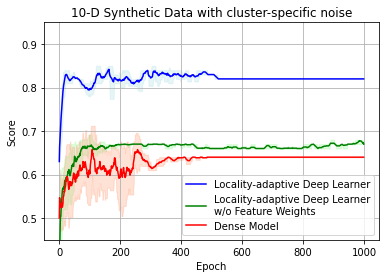

In [153]:
%matplotlib inline

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch'])
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, i in enumerate(["AttentionModelwFeatWeights_val",
          "AttentionModelwoFeatWeights_val", 
          "DenseModel_val"
         ]):
    x_plot=df['Epoch']
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", "Locality-adaptive Deep Learner\nw/o Feature Weights", "Dense Model"], 
          loc=("lower right"))#(1,0.6))
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
plt.savefig(savefile)

In [145]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
n_estimators_list=[200,500,1000]
n_repeats=10
random_seeds=range(n_repeats)
min_samples_list=list(range(1,11))
RF_results=[]

for n_estimator in n_estimators_list:
    for min_samples in min_samples_list:
        for i in range(n_repeats):
            np.random.seed(random_seeds[i])
            clf=ExtraTreesClassifier(n_estimators=n_estimator, 
                                     min_samples_leaf=min_samples,
                                     bootstrap=True, 
                                     oob_score=True, 
                                     class_weight="balanced_subsample")
            clf=clf.fit(X_train, y_train)
            train_score=clf.score(X_train, y_train)
            test_score=clf.score(X_test, y_test)
            RF_results.append([n_estimator, min_samples, "train_accuracy", train_score])
            RF_results.append([n_estimator, min_samples, "test_accuracy", test_score])
        
RF_results=pd.DataFrame(RF_results, columns=["n_estimator", "min_samples_leaf", "metric", "score"])

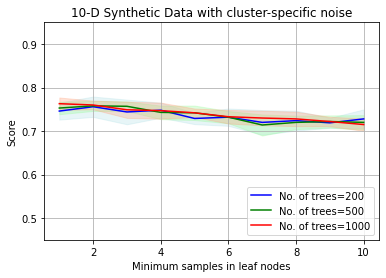

In [154]:
%matplotlib inline

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=RF_results.query("n_estimator == @n_estimator & metric == 'test_accuracy' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='min_samples_leaf',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Minimum samples in leaf nodes")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("lower right"))
ax.set_title("10-D Synthetic Data with cluster-specific noise")

plt.grid()
savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
plt.savefig(savefile)

#### For checking ellipse code

In [158]:
def get_ellipsoid(means, eig_vec, eig_val, d_angle=np.pi/20, n_std=2.0):
    # Get points on the circle around unit sphere (x**2 + y**2 = 1), then project onto the 3 principal semi-axes. 
    # Stretch principal semi-axes by n_std, then translate ellipse by means
    ### TBD: Figure out how to ensure that z-axis is the minor semi-axes in ellipse
    
    #Sort (descending) eig_val and eig_vec
    if eig_val.ndim==2:
        eig_val=np.diag(eig_val)        
    
    psi=np.arange(0, 2*np.pi, d_angle)
    theta=np.arange(0, 2*np.pi, d_angle)
    rot= lambda psi, theta: np.array([np.cos(psi)*np.sin(theta), 
                                      np.sin(psi)*np.sin(theta),
                                      np.cos(theta)
                                     ])
    points=[rot(p, t) for t in theta for p in psi] #points in a circle around a unit sphere

    std_scale=np.sqrt(eig_val)*n_std
    ellipse_vec=np.multiply(std_scale, eig_vec)
    points=[np.dot(p, ellipse_vec.transpose()) for p in points] #Points in an ellipse around the ellipsoid
    
    points=points+means
    points=np.concatenate([points, [points[0]]])
    return points

<IPython.core.display.Javascript object>


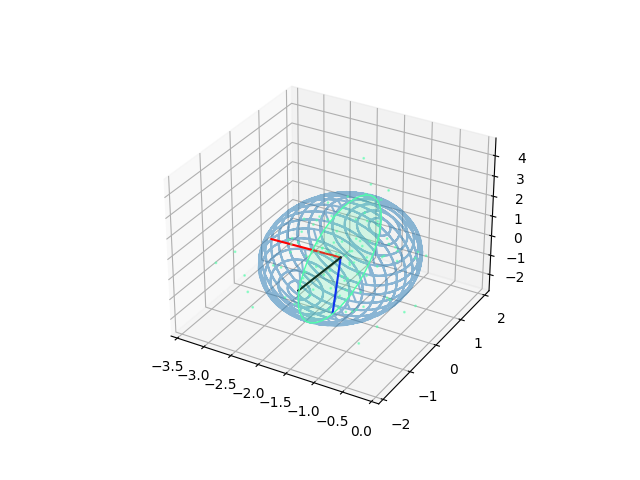

In [159]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure()
ax = fig.gca(projection='3d')

C=cluster_labels_train
normalize = mcolors.Normalize(vmin=np.min(C), vmax=np.max(C))
colormap = cm.jet

for cl in [4]:
    cl_ind=np.where(cluster_labels_train==cl)[0]
    S=np.cov(out[cl_ind,:3].transpose())
    eig_val, eig_vec = np.linalg.eig(S)
    means=np.mean(out[cl_ind,:3], axis=0)

    c=colormap(normalize(C[cl_ind]))[0]
    ax.scatter(out[cl_ind,0], out[cl_ind,1], out[cl_ind,2], s=1, color=c, alpha=0.5)

    #Plot 3D ellipse based on mean and std of the points
    points=get_ellipse_in_3D(means, eig_vec, eig_val)
    verts = [list(zip(points[:,0], points[:,1], points[:,2]))]

#     ax.plot(points[:,0],points[:,1], points[:,2], color=c)
    ax.add_collection3d(Poly3DCollection(verts, color=c, alpha=0.2),)
    
    points2=get_ellipsoid(means, eig_vec, eig_val)
    
    ax.plot(points2[:,0],points2[:,1],points2[:,2], alpha=0.5)
    
    #Plot principal semi-axes
    std_devs=np.sqrt(eig_val)*2
    xyz_=np.multiply(std_devs, eig_vec)
    col=['b','r','k']
    for i in range(3):        
        ax.plot([0,xyz_[0,i]]+means[0],[0,xyz_[1,i]]+means[1],[0,xyz_[2,i]]+means[2],c=col[i])